In [18]:
import pandas as pd
from pykalman import KalmanFilter

In [2]:
file_path = "./safety/features/part-0000{}-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv"
features_arr = []
for i in range(10):
    features_arr.append(pd.read_csv(file_path.format(i)))

In [3]:
label = pd.read_csv("./safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [4]:
label['bookingID'] = label['bookingID'].astype(str)

In [5]:
features_arr[0].head(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


In [6]:
for df in features_arr:
    df['bookingID'] = df['bookingID'].astype(str)

In [7]:
all_features = pd.concat(features_arr)

## Event Detection
Given the sensor values, we need to detect if the driver make reckless driving activities, such as hard breaking, hard acceleration, and weaving. For this purpose, we'll take a trip with longest duration as dataset and use clustering algorithm to detect those events

In [8]:
import numpy as np

In [9]:
a = np.array([2,3])
b = np.array([1,2])
c = np.nan
if np.isnan(c):
    print("nan")

nan


In [22]:
class DrivingEventDetection:
    def __init__(self, dataframe):
        self.data = dataframe
    
    def kalman_filter(self, columns):
        for column in columns:
            kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
            measurement = self.data[column]
            mean, variance = kf.em(measurement).filter(measurement)
            new_column_name = 'new_{}'.format(column)
            self.data[new_column_name] = mean
    
    def drop_columns(self, columns):
        self.data = self.data.drop(columns, axis=1)
    
    def teta(self, y):
        teta = np.arccos(y / 9.800)
        return teta
    
    def pie(self, x, z):
        pie = np.arctan(z/x)
        return pie
    
    def reOrientX(self, x, y, z):
        mult = np.multiply
        teta = self.teta(y)
        pie = self.pie(x, z)
        xPie = mult(x, np.cos(pie)) - mult(z, np.sin(pie))
        yPie = y
        zPie = mult(x, np.sin(pie)) + mult(z, np.cos(pie))
        xTeta = mult(xPie, np.cos(teta)) + mult(yPie, np.sin(teta))
        zTeta = zPie
        alpha = np.arctan(xPie / zPie)
        xAlpha = mult(xTeta, np.cos(alpha)) - mult(zTeta, np.sin(alpha))
        return xAlpha
    
    def reOrientY(self, x, y, z):
        mult = np.multiply
        teta = self.teta(y)
        pie = self.pie(x, z)
        xPie = mult(x, np.cos(pie)) - mult(z, np.sin(pie))
        yPie = y
        yTeta = mult(-xPie, np.sin(teta)) + mult(yPie, np.cos(teta))
        return yTeta
    
    def reOrientZ(self, x, y, z):
        mult = np.multiply
        teta = self.teta(y)
        pie = self.pie(x, z)
        xPie = mult(x, np.cos(pie)) - mult(z, np.sin(pie))
        yPie = y
        zPie = mult(x, np.sin(pie)) + mult(z, np.cos(pie))
        xTeta = mult(xPie, np.cos(teta)) + mult(yPie, np.sin(teta))
        zTeta = zPie
        alpha = np.arctan(xPie / zPie)
        zAlpha = mult(xTeta, np.sin(alpha)) + mult(zTeta, np.cos(alpha))
        return zAlpha

In [11]:
grouped = all_features.groupby('bookingID', sort=False)

In [12]:
longest_trip_id = grouped.size().sort_values(ascending=False).head(1).index.values[0]

In [13]:
longest_trip = grouped.get_group(longest_trip_id)

In [14]:
data = longest_trip.sort_values('second')

In [23]:
driving_event_detection = DrivingEventDetection(data)

In [41]:
driving_event_detection.data.head(10)

,bookingID,Accuracy,Bearing,acceleration_y,gyro_z,second,Speed,new_acceleration_y,new_gyro_z
688080,438086664371,4.0,351.0,10.928333,-0.096468,0.0,7.340000,9.811568,-0.096718
1554664,438086664371,4.0,351.0,9.346964,-0.191152,1.0,9.540000,9.616936,-0.129889
1038426,438086664371,4.0,352.0,9.793482,0.015321,2.0,9.700000,9.709002,-0.064576
746317,438086664371,4.0,352.0,9.490616,0.002492,3.0,9.440000,9.590229,-0.032512
77421,438086664371,4.0,350.0,9.014170,0.128331,4.0,9.420000,9.274274,0.045605
992307,438086664371,5.0,350.0,8.300697,0.021429,5.0,8.990000,8.739376,0.033815
400858,438086664371,5.0,350.0,9.385271,0.129552,6.0,10.490000,9.094363,0.080554
624754,438086664371,5.0,349.0,10.576386,0.031203,7.0,11.090000,9.908948,0.056454
1336458,438086664371,5.0,347.0,10.296265,-0.054318,8.0,10.290000,10.121838,0.002356
300509,438086664371,5.0,346.0,10.843340,0.230956,9.0,9.139999,10.518414,0.114000


#### Remove x and z axes from accelerometer and x and y axes gyro
Since the vehicle only has longitudinal and lateral motion, x and z axes in accelerometer and x and y axes in gyro can be omitted

In [24]:
driving_event_detection.drop_columns(["acceleration_x", "acceleration_z", "gyro_x", "gyro_y"])

#### Sensor-captured data filtering with kalman filter to reduce noise

In [26]:
driving_event_detection.kalman_filter(["acceleration_y", "gyro_z"])

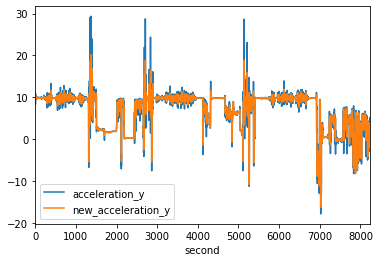

In [32]:
driving_event_detection.data.plot.line(x="second", y=["acceleration_y", "new_acceleration_y"])

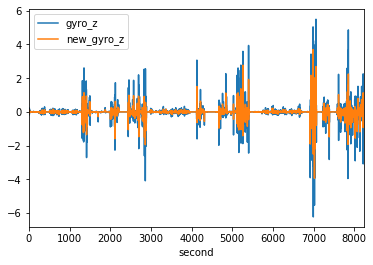

In [28]:
driving_event_detection.data.plot.line(x="second", y=["gyro_z", "new_gyro_z"])

#### Sliding Window
Sliding window with value of 3. Statistical features such as interquartile range of acceleration and gyro, average speed

In [44]:
import scipy.stats as stats

In [287]:
stats_features = {}
stats_features['acceleration_y_window_iqr'] = driving_event_detection.data['new_acceleration_y'].rolling(3).apply(lambda x: stats.iqr(x), raw=True)
stats_features['gyro_z_window_iqr'] = driving_event_detection.data['new_gyro_z'].rolling(3).apply(lambda x: stats.iqr(x), raw=True)
# stats_features['speed_window_mean'] = driving_event_detection.data['Speed'].rolling(3).mean()

In [288]:
train_data = pd.DataFrame.from_dict(stats_features).reset_index(drop=True)

In [289]:
train_data = train_data.dropna()

In [290]:
train_data.head(10)

,acceleration_y_window_iqr,gyro_z_window_iqr
2,0.097316,0.032656
3,0.059386,0.048688
4,0.217364,0.055090
5,0.425426,0.039059
6,0.267449,0.023369
7,0.584786,0.023369
8,0.513737,0.039099
9,0.304733,0.055822
10,0.204495,0.055822
11,0.230131,0.082428


#### Clustering
4 clusters

In [291]:
from sklearn.cluster import KMeans

In [292]:
from mpl_toolkits import mplot3d

In [293]:
%matplotlib inline
import matplotlib.pyplot as plt

In [294]:
km = KMeans(n_clusters=4)

In [295]:
km.fit(train_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [296]:
from matplotlib.pyplot import figure

In [300]:
centroids

array([[0.09011464, 0.01815251],
       [4.05710534, 0.37176346],
       [0.61147226, 0.12803084],
       [1.73309816, 0.36650824]])

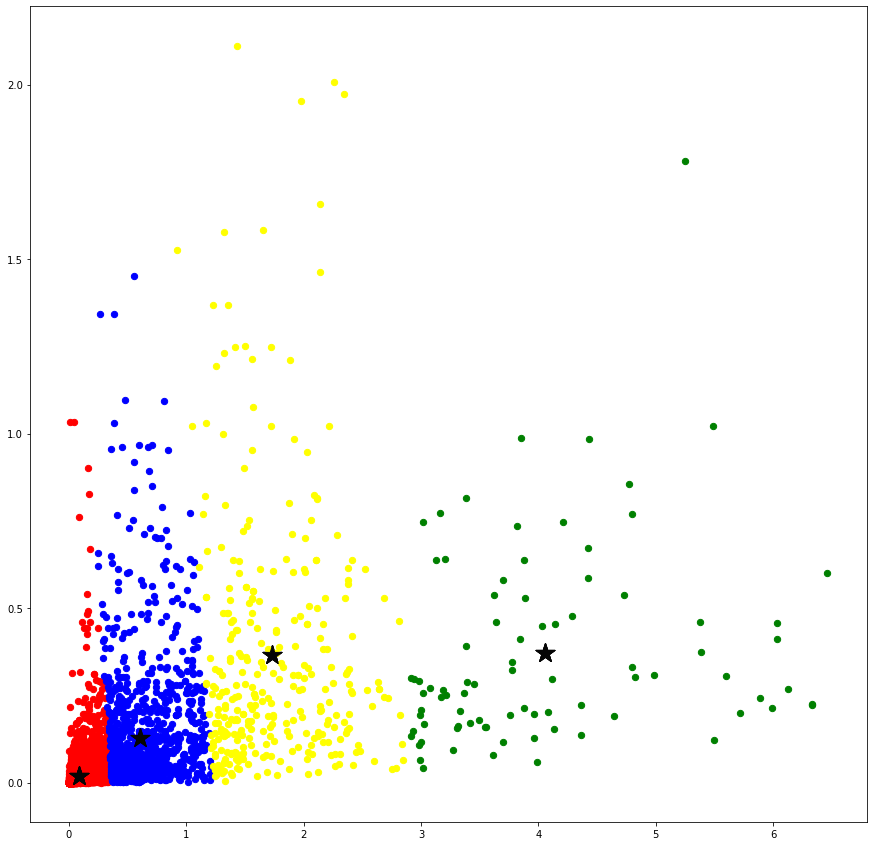

In [299]:
colors = ['r', 'g', 'b', 'yellow']
figure(figsize=(15,15))
k=4
x_arr = train_data.values
labels = km.labels_
centroids = km.cluster_centers_
for i in range(k):
    points = np.array([x_arr[j] for j in range(len(train_data)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], s=40, c=colors[i])
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=400,
c='#050505')
plt.show()

### Sensor Noise Reduction

In [16]:
def kalman_filter(dataframe, columns):
    dataframe = dataframe.copy()
    for column in columns:
        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
        measurement = dataframe[column]
        mean, variance = kf.em(measurement).filter(measurement)
        new_column_name = 'new_{}'.format(column)
        dataframe[new_column_name] = mean
    return dataframe

In [ ]:
kalman_filter(grouped_by_booking_id.get_group("1202590843006"), ["acceleration_x", "acceleration_y",
                                                                 "acceleration_z",
                                                                 "gyro_x", "gyro_y", "gyro_z",]).head(10)

In [ ]:
data_corrected = []

## Coordinate Reorientation
Since the axes in the dataset are smartphone's coordinate system and the smartphone can be fixed in the vehicle in any orientation, we must align the smartphone's coordinate system with the vehicles' [1]

In [ ]:
import numpy as np

In [ ]:
np.array([2,3]) - np.array([1,2])

In [ ]:
def add_beta_angle_to_df(df, beta_angle_arr):
    df['beta'] = beta_angle_arr
    return df

In [ ]:
def add_alpha_angle_to_df(df, alpha_angle_arr):
    df['alpha'] = alpha_angle_arr
    return df